In [1]:
%run test_classifier2ST.py
from sklearn import metrics, model_selection
from autogluon.tabular import TabularPredictor
import plotnine as p9
import bisect

In [2]:
train, test = load_adult_data()

In [3]:
train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,178478,Bachelors,13,Never-married,Tech-support,Own-child,White,Female,0,0,40,United-States,<=50K
1,23,State-gov,61743,5th-6th,3,Never-married,Transport-moving,Not-in-family,White,Male,0,0,35,United-States,<=50K
2,46,Private,376789,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,15,United-States,<=50K
3,55,?,200235,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,50,United-States,>50K
4,36,Private,224541,7th-8th,4,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,0,0,40,El-Salvador,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39068,54,Private,83103,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,67,United-States,<=50K
39069,23,Private,172232,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,53,United-States,<=50K
39070,37,Local-gov,165883,HS-grad,9,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
39071,26,Self-emp-not-inc,67240,HS-grad,9,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,35,United-States,<=50K


In [4]:
train[['marital-status']].value_counts(normalize=True)

marital-status        
 Married-civ-spouse       0.458705
 Never-married            0.330586
 Divorced                 0.134338
 Separated                0.031787
 Widowed                  0.031377
 Married-spouse-absent    0.012592
 Married-AF-spouse        0.000614
dtype: float64

In [5]:
pred = TabularPredictor(label='class').fit(train)

No path specified. Models will be saved in: "AutogluonModels/ag-20220627_173245/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220627_173245/"
AutoGluon Version:  0.4.3b20220616
Python Version:     3.8.0
Operating System:   Linux
Train Data Rows:    39073
Train Data Columns: 14
Label Column: class
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [' <=50K', ' >50K']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive ( >50K) vs negative ( <=50K) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or 

In [6]:
yhat = pred.predict(test)
metrics.accuracy_score(yhat, test['class'])

0.8763435356740711

In [7]:
pred.feature_importance(test)

Computing feature importance via permutation shuffling for 14 features using 5000 rows with 5 shuffle sets...
	20.57s	= Expected runtime (4.11s per shuffle set)
	17.32s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
capital-gain,0.04804,0.004401,0.000008,5,0.057102,0.038978
marital-status,0.03164,0.002851,0.000008,5,0.037510,0.025770
education-num,0.01824,0.003468,0.000150,5,0.025381,0.011099
occupation,0.01736,0.002269,0.000034,5,0.022032,0.012688
age,0.01724,0.004080,0.000350,5,0.025641,0.008839
capital-loss,0.01212,0.001724,0.000048,5,0.015670,0.008570
relationship,0.00636,0.003330,0.006471,5,0.013216,-0.000496
hours-per-week,0.00628,0.002722,0.003354,5,0.011886,0.000674
workclass,0.00456,0.001621,0.001632,5,0.007898,0.001222
fnlwgt,0.00284,0.000942,0.001263,5,0.004780,0.000900


In [9]:
data = pd.concat((train, test))

In [10]:
data.loc[:,'race'] = data['race'].str.strip()
data.loc[:,'sex'] = data['sex'].str.strip()
data.loc[:,'marital-status'] = data['marital-status'].str.strip()

In [11]:
data.index = pd.Index(range(data.shape[0]))

In [12]:
data_white = data['marital-status']=="Married-civ-spouse"

In [13]:
train_prop = 0.5

In [110]:
p_nonwhite = .75
p_white = (0.5 + data_white.mean() - p_nonwhite) / data_white.mean()

In [111]:
train_p = data_white * p_white + (1 - data_white) * p_nonwhite

In [112]:
p_nonwhite

0.75

In [113]:
train_p

0        0.750000
1        0.750000
2        0.750000
3        0.454377
4        0.454377
           ...   
48837    0.750000
48838    0.750000
48839    0.454377
48840    0.750000
48841    0.454377
Name: marital-status, Length: 48842, dtype: float64

In [114]:
train_ind = np.random.binomial(1,train_p) == 1

In [115]:
train_cs = data[train_ind]
test_cs = data[~train_ind]
train_cs, val_cs = model_selection.train_test_split(train_cs)

In [116]:
train_cs.value_counts('marital-status',normalize=True)

marital-status
Never-married            0.404590
Married-civ-spouse       0.335432
Divorced                 0.165327
Widowed                  0.039423
Separated                0.037503
Married-spouse-absent    0.016698
Married-AF-spouse        0.001027
dtype: float64

In [117]:
test_cs.value_counts('marital-status',normalize=True)

marital-status
Married-civ-spouse       0.648364
Never-married            0.212046
Divorced                 0.089108
Separated                0.022237
Widowed                  0.019972
Married-spouse-absent    0.008062
Married-AF-spouse        0.000211
dtype: float64

In [118]:
(test_cs['class'] == " <=50K").mean()

0.6850924803709754

In [119]:
(val_cs['class'] == " <=50K").mean()

0.8068836212669077

In [120]:
pred_cs = TabularPredictor(label='class').fit(train_cs)

No path specified. Models will be saved in: "AutogluonModels/ag-20220627_181429/"
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220627_181429/"
AutoGluon Version:  0.4.3b20220616
Python Version:     3.8.0
Operating System:   Linux
Train Data Rows:    22398
Train Data Columns: 14
Label Column: class
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [' <=50K', ' >50K']
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 =  >50K, class 0 =  <=50K
	Note: For your binary classification, AutoGluon arbitrarily selected which label-value represents positive ( >50K) vs negative ( <=50K) class.
	To explicitly set the positive_class, either rename classes to 1 and 0, or 

In [121]:
yhat_cs = pred_cs.predict(test_cs)
metrics.accuracy_score(yhat_cs, test_cs['class'])

0.829635875006587

In [122]:
%run ../../../src/autogluon/shift/models/classifier2ST.py

In [123]:
label='label'
cs_pred = TabularPredictor(label=label)
ctst = Classifier2ST(cs_pred)

No path specified. Models will be saved in: "AutogluonModels/ag-20220627_181559/"


In [124]:
ctst.fit((train_cs.drop(columns='class'), test_cs.drop(columns='class')))

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20220627_181559/"
AutoGluon Version:  0.4.3b20220616
Python Version:     3.8.0
Operating System:   Linux
Train Data Rows:    20688
Train Data Columns: 14
Label Column: label
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    15013.92 MB
	Train Data (Original)  Memory Usage: 12.07 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify s

In [125]:
ctst.test_stat

0.6592062648039831

In [126]:
ano_samp = ctst.sample_anomaly_scores()
ano_data = data.loc[ano_samp.index]

In [127]:
ano_data['rank'] = ano_samp['rank']

In [128]:
ano_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,rank
19850,47,Federal-gov,68493,HS-grad,9,Married-civ-spouse,Adm-clerical,Husband,Black,Male,0,0,40,United-States,>50K,1.000000
40297,49,Self-emp-not-inc,168191,7th-8th,4,Married-civ-spouse,Other-service,Husband,White,Male,0,0,70,Italy,<=50K,0.989899
17070,26,Private,109186,Some-college,10,Married-civ-spouse,Sales,Husband,White,Male,0,0,50,Germany,<=50K,0.979798
21960,60,Federal-gov,129379,Some-college,10,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,United-States,<=50K,0.969697
11573,39,Private,53926,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K,0.959596


/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/stats/stat_density.py:151: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/stats/stat_density.py:154: PlotnineWarning: Groups with fewer than 2 data points have been removed.


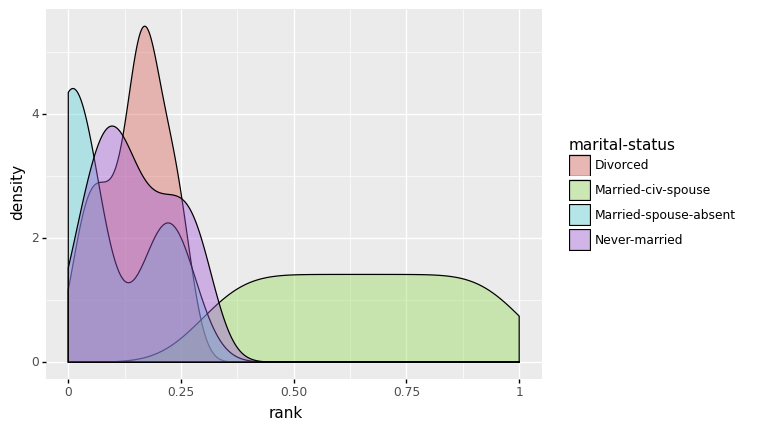

<ggplot: (8735268653400)>

In [129]:
p9.ggplot(ano_data, p9.aes(x='rank', fill='marital-status')) + p9.geom_density(alpha=.4)

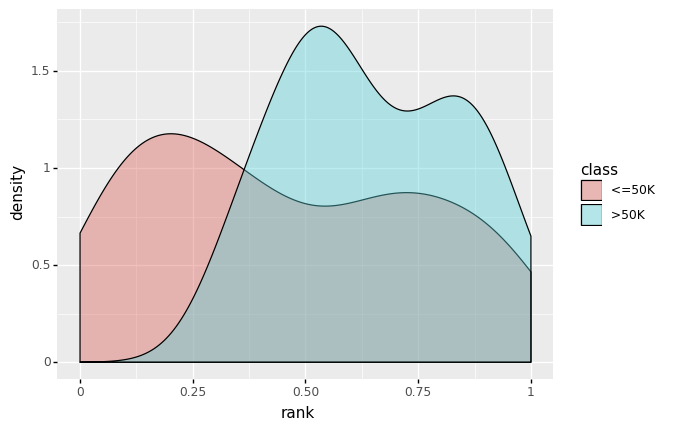

<ggplot: (8735268643325)>

In [130]:
p9.ggplot(ano_data, p9.aes(x='rank', fill='class')) + p9.geom_density(alpha=.4)

In [131]:
ctst.feature_importance()

Computing feature importance via permutation shuffling for 14 features using 5000 rows with 5 shuffle sets...
	29.8s	= Expected runtime (5.96s per shuffle set)
	13.88s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
marital-status,0.15016,0.012555,0.000006,5,0.176011,0.124309
fnlwgt,0.00056,0.000590,0.050519,5,0.001775,-0.000655
relationship,0.00032,0.001677,0.345779,5,0.003773,-0.003133
occupation,0.00016,0.000792,0.337524,5,0.001792,-0.001472
workclass,0.00016,0.000358,0.186950,5,0.000897,-0.000577
age,0.00004,0.000910,0.463214,5,0.001914,-0.001834
capital-gain,0.00004,0.000329,0.399483,5,0.000717,-0.000637
sex,-0.00012,0.000268,0.813050,5,0.000432,-0.000672
education,-0.00020,0.000510,0.785013,5,0.000850,-0.001250
capital-loss,-0.00020,0.000400,0.836918,5,0.000624,-0.001024


In [132]:
phat_val = ctst._classifier.predict_proba(val_cs)

In [133]:
phat_val[1].mean()

0.4197362440528361

In [134]:
ctst._classifier.predict(val_cs).mean()

0.3402973081558859

In [135]:
yhat_val = pred_cs.predict(val_cs)
y_val = val_cs['class']
odds_val = phat_val[1] / phat_val[0]

In [136]:
phat_val[1].mean()

0.4197362440528361

In [137]:
odds_val.mean()

0.8767605327458683

In [138]:
(odds_val * (y_val == yhat_val)).mean()

0.7302265885613611

In [139]:
odds_val_sorted = odds_val.sort_values()

In [140]:
phat_test = ctst._classifier.predict_proba(test_cs)
odds_test = phat_test[1] / phat_test[0]

In [141]:
next_idx = odds_val_sorted.searchsorted(odds_test)
prev_idx = next_idx - 1

In [142]:
val_sidx = odds_val_sorted.index

In [143]:
def idx_choice(i):
    choice = np.random.binomial(1,0.5)
    if choice == 1:
        if prev_idx[i] < 0:
            return val_sidx[next_idx[i]]
        return val_sidx[prev_idx[i]]
    else:
        if next_idx[i] >= odds_val_sorted.shape[0]:
            return val_sidx[prev_idx[i]]
        return val_sidx[next_idx[i]]
    
neigh_idx = [idx_choice(i) for i in range(odds_test.shape[0])]

In [144]:
yhat_neigh = pred_cs.predict(val_cs.loc[neigh_idx])

In [145]:
y_neigh = val_cs.loc[neigh_idx]['class']

In [146]:
(y_neigh == yhat_neigh).mean()

0.8343257627654529

In [147]:
(y_neigh == yhat_neigh)

39509     True
35375    False
26945     True
33032    False
43739    False
         ...  
24820     True
15759     True
31402     True
7628      True
35258     True
Name: class, Length: 18977, dtype: bool

In [148]:
(val_cs['class'] == ' <=50K').mean()

0.8068836212669077

In [149]:
yhat_val = pred_cs.predict(val_cs)
y_val = val_cs['class']

In [150]:
(y_val == yhat_val).mean()

0.8928619258068836

In [61]:
val_cs

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
11392,45,Self-emp-not-inc,142871,Some-college,10,Separated,Sales,Unmarried,White,Male,0,0,50,United-States,<=50K
2593,20,Private,278155,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,40,United-States,<=50K
22756,51,Federal-gov,378126,HS-grad,9,Divorced,Adm-clerical,Unmarried,White,Female,0,1980,40,United-States,<=50K
21927,36,Private,257691,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,20,United-States,<=50K
45369,23,Private,287681,7th-8th,4,Never-married,Other-service,Not-in-family,White,Male,0,0,25,Mexico,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4322,25,Private,207965,Bachelors,13,Never-married,Other-service,Not-in-family,White,Female,0,0,60,United-States,<=50K
7875,24,Private,72143,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,20,United-States,<=50K
39939,44,Private,335248,Some-college,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
33313,29,Private,354496,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K


In [62]:
nn_counts = pd.Series(neigh_idx).value_counts()

In [63]:
nn_counts

488      1269
2456     1175
32240    1048
1329      927
3222      468
         ... 
22549       1
45757       1
4255        1
16226       1
33516       1
Length: 2141, dtype: int64

In [64]:
phat_pred_val = pred_cs.predict_proba(val_cs)

In [65]:
phat_pred_val['nn_counts'] = nn_counts

In [66]:
phat_pred_val.fillna(0)

,<=50K,>50K,nn_counts
11392,0.875985,0.124015,7.0
2593,0.997466,0.002534,1.0
22756,0.981193,0.018807,0.0
21927,0.961245,0.038755,0.0
45369,0.998966,0.001034,1.0
...,...,...,...
4322,0.966638,0.033362,0.0
7875,0.990981,0.009020,0.0
39939,0.975292,0.024708,0.0
33313,0.900623,0.099377,0.0


/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 4537 rows containing missing values.


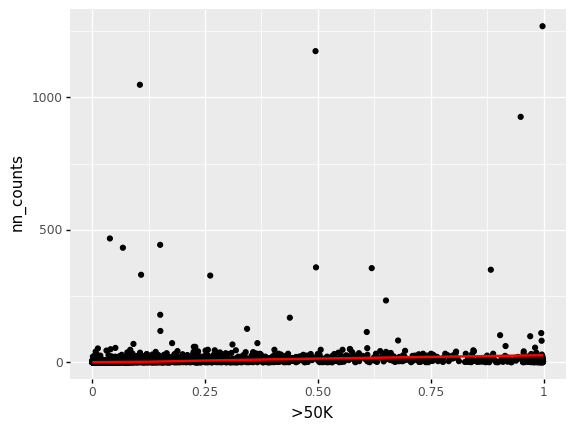

<ggplot: (8735268742391)>

In [67]:
p9.ggplot(phat_pred_val, p9.aes(x = ' >50K', y='nn_counts')) + p9.geom_point()\
+ p9.stat_smooth(method='lowess', color='red')

/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_ydensity : Removed 4537 rows containing non-finite values.
/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/stats/stat_density.py:151: PlotnineWarning: To compute the density of a group with only one value set the bandwidth manually. e.g `bw=0.1`
/home/ubuntu/autogluon/env/lib/python3.8/site-packages/plotnine/stats/stat_density.py:154: PlotnineWarning: Groups with fewer than 2 data points have been removed.


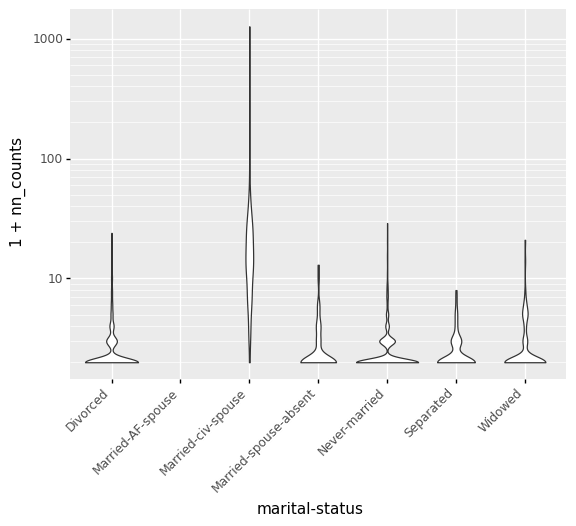

<ggplot: (8735268703386)>

In [68]:
p9.ggplot(val_cs, p9.aes(x='marital-status', y='1 + nn_counts')) + p9.geom_violin()\
+ p9.scale_y_log10() + p9.theme(axis_text_x=p9.element_text(rotation=45, hjust=1))

In [69]:
pd.DataFrame(
    {
        'train': train_cs.value_counts('marital-status', normalize=True),
        'test': test_cs.value_counts('marital-status', normalize=True)
    }
)

,train,test
marital-status,,
Divorced,0.223143,0.031177
Married-AF-spouse,0.001198,0.000136
Married-civ-spouse,0.106879,0.881800
Married-spouse-absent,0.020367,0.002666
Never-married,0.545477,0.072158
Separated,0.051967,0.005603
Widowed,0.050968,0.006461


In [70]:
yhat_test = pred_cs.predict(test_cs)
yhat_val = pred_cs.predict(val_cs)

In [71]:
yhat_val.value_counts(normalize=True)

 <=50K    0.932914
 >50K     0.067086
Name: class, dtype: float64

In [72]:
yhat_test.value_counts(normalize=True)

 <=50K    0.653443
 >50K     0.346557
Name: class, dtype: float64

In [73]:
label_ct = pd.DataFrame(
{
    'val': yhat_val.value_counts(),
    'test': yhat_test.value_counts()
}
)

In [74]:
from scipy import stats

In [75]:
stats.fisher_exact(label_ct)

(7.375254978564514, 0.0)

In [76]:
val_cs['yhat'] = yhat_val

In [77]:
pjoint_dist = val_cs.value_counts(['class','yhat'], normalize = True)

In [78]:
pcond_dist = pjoint_dist / pjoint_dist.groupby(level=0).sum()

In [79]:
q_yhat = yhat_test.value_counts(normalize=True)

In [80]:
q_yhat

 <=50K    0.653443
 >50K     0.346557
Name: class, dtype: float64

In [81]:
P_jnt = pd.pivot(pcond_dist.reset_index(), index='class', columns='yhat').T.values

In [82]:
q_yhat

 <=50K    0.653443
 >50K     0.346557
Name: class, dtype: float64

In [83]:
np.linalg.solve(P_jnt, q_yhat)

array([0.35231601, 0.64768399])

In [84]:
P_jnt

array([[0.9853211 , 0.47291362],
       [0.0146789 , 0.52708638]])

In [85]:
pjoint_dist

class   yhat  
 <=50K   <=50K    0.884546
 >50K    >50K     0.053908
         <=50K    0.048368
 <=50K   >50K     0.013178
dtype: float64

In [86]:
test_cs.value_counts('class',normalize=True)

class
 <=50K    0.599539
 >50K     0.400461
dtype: float64